## Projeto: Identificar fraude no email da Enron ##

### Visão Geral ###

Em 2000, Enron era uma das maiores empresas dos Estados Unidos.<br>
Já em 2002, ela colapsou e quebrou devido a uma fraude que envolveu grande parte da corporação.<br>
Resultando em uma investigação federal, muitos dados que são normalmente confidenciais, se tornaram públicos, incluindo dezenas de milhares de e-mails e detalhes financeiros para os executivos dos mais altos níveis da empresa.

### Objetivo ###

Construção de um modelo preditivo que visará determinar se um funcionário é ou não um funcionário de interesse (POI).<br>
Um funcionário de interesse é um funcionário que participou do escândalo da empresa Enron.

In [1]:
# Importing all we need for this project

#!/usr/bin/python
from time import time
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,  GridSearchCV, StratifiedShuffleSplit

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use. ###

In [2]:
with open("final_project_dataset_2.pkl", "rb") as data_file: 
    data_dict = pickle.load(data_file)

In [3]:
# Converting data to a Pandas dataframe
enron_df = pd.DataFrame.from_records(list(data_dict.values()))
enron_df.head(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
1,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
2,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
3,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
4,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [4]:
# Paste dataframe content to be a series of employees
employees = pd.Series(list(data_dict.keys()))
enron_df.set_index(employees, inplace=True)

In [5]:
#Exploring data
print('Number of features:', len(enron_df.columns))
print('Number of employees:', len(employees))

poi_count = 0
for person in data_dict:
	if data_dict[person]["poi"]==1:
		poi_count +=1 
print("Number of POI in dataset:", poi_count)

Number of features: 21
Number of employees: 146
Number of POI in dataset: 18


In [6]:
enron_df.head(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [7]:
enron_df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                            bool
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

Notamos que, com execeção a 'poi', todos os atributos são do tipo 'object'.<br>
Resolveremos isso mudando o tipo para numérico (int ou float).<br>

In [8]:
enron_df = enron_df.apply(lambda x : pd.to_numeric(x, errors = 'coerce'))
enron_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,NaN,NaN,NaN,NaN,NaN,94299.0,29.0,38.0,1.0,...,NaN,1740.0,False,585062.0,NaN,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,NaN,NaN,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,NaN,-400729.0,NaN,NaN,4890344.0,78552.0,NaN,NaN,NaN,...,NaN,12961.0,False,1788391.0,NaN,170941.0,NaN,NaN,211725.0,6678735.0
CORDES WILLIAM R,NaN,NaN,NaN,NaN,NaN,651850.0,NaN,12.0,10.0,0.0,...,NaN,NaN,False,386335.0,NaN,NaN,58.0,764.0,NaN,1038185.0
HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,NaN,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0


In [9]:
# Finding the quantity of NaN values
list_missing_values = []
for feature in enron_df.columns:
    list_missing_values.append(enron_df[feature].isnull().sum())
print(list_missing_values)

[64, 107, 97, 129, 146, 44, 51, 60, 60, 60, 142, 80, 53, 0, 36, 128, 51, 60, 60, 21, 20]


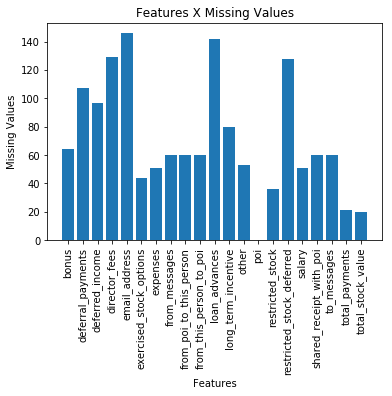

In [10]:
plt.bar(enron_df.columns, list_missing_values)
plt.xlabel("Features")
plt.xticks(rotation='vertical')
plt.ylabel("Missing Values")
plt.title("Features X Missing Values")
plt.show()

Notamos que há muitos valores NaN (Not A Number) em nosso dataframe.<br>
O fato do atributo 'email_address' ser mostrado com todos os valores 'NaN' deve ser desconsiderado, pois isso ocorreu devido a mudança dos tipos dos dados para numérico. Como esse atributo não é relevante para nossa investigação, iremos removê-lo.<br>
Existem outros atributos com muitos valores 'NaN',por exemplo 'director_fees' e 'loan_advances', mas optaremos em deixar esses dados por enquanto.<br> 
Os demais valores 'NaN' serão substituídos por zero.

In [11]:
#Removing 'email_address'
df_copy = enron_df
df_copy = df_copy.drop('email_address', axis=1)
df_copy = df_copy.fillna(0)
print('Number of features:', len(df_copy.columns))

Number of features: 20


In [12]:
df_copy.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,0.0,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


No final os atributos escolhidos foram:

In [13]:
features_list = ['poi','salary', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees',
                 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person',
				 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other',
				 'restricted_stock', 'restricted_stock_deferred','shared_receipt_with_poi',
                 'to_messages', 'total_payments', 'total_stock_value']

### Task 2: Remove outliers ###

Analisaremos alguns atributos para verificarmos se há a existência de outliers no nosso conjunto de dados.

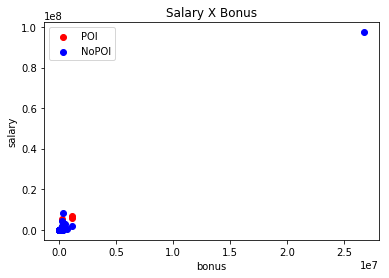

In [14]:
plt.scatter(df_copy['salary'][df_copy['poi'] == True],df_copy['bonus'][df_copy['poi'] == True],color = 'red', label = 'POI')
plt.scatter(df_copy['salary'][df_copy['poi'] == False],df_copy['bonus'][df_copy['poi'] == False],color = 'blue', label = 'NoPOI')

plt.xlabel("bonus")
plt.ylabel("salary")
plt.title("Salary X Bonus")
plt.legend(loc='best')
plt.show()

In [15]:
df_copy['salary'].idxmax()

'TOTAL'

Verificamos bem nitidamente um outlier no gráfico 'bonus x salary' e na cécula acima temos que trata-se do 'TOTAL'.<br>
Portanto, iremos remover esse outlier e veremos como ficará o gráfico.

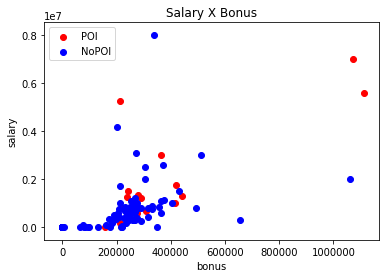

In [16]:
#Removendo o primeiro outlier: TOTAL
df_copy = df_copy.drop('TOTAL', axis=0)

plt.scatter(df_copy['salary'][df_copy['poi'] == True],df_copy['bonus'][df_copy['poi'] == True],color = 'red', label = 'POI')
plt.scatter(df_copy['salary'][df_copy['poi'] == False],df_copy['bonus'][df_copy['poi'] == False],color = 'blue', label = 'NoPOI')

plt.xlabel("bonus")
plt.ylabel("salary")
plt.title("Salary X Bonus")
plt.legend(loc='best')
plt.show()

Após a remoção do outlier temos um gráfico com valores um mais espalhados e coerente.

Segundo o arquivo 'enron61702insiderpay.pdf' cedido pela FindLaw, temos um dado com o nome 'THE TRAVEL AGENCY IN THE PARK'.
Verificaremos se há alguma informação importante nesse dado.

In [17]:
df_copy.loc['THE TRAVEL AGENCY IN THE PARK']

bonus                             0
deferral_payments                 0
deferred_income                   0
director_fees                     0
exercised_stock_options           0
expenses                          0
from_messages                     0
from_poi_to_this_person           0
from_this_person_to_poi           0
loan_advances                     0
long_term_incentive               0
other                        362096
poi                           False
restricted_stock                  0
restricted_stock_deferred         0
salary                            0
shared_receipt_with_poi           0
to_messages                       0
total_payments               362096
total_stock_value                 0
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

Notamos que, com exceção a 'total_payments', 'other' e 'poi', os valores dos seus atributos são zero.<br>
Com isso, faremos a remoção por se tratar de um outlier de valores muito baixos.

In [18]:
# Removendo o segundo outlier: THE TRAVEL AGENCY IN THE PARK
df_copy = df_copy.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0)

Agora verificaremos a relação entre 'total_payments' e 'deferral_payments'

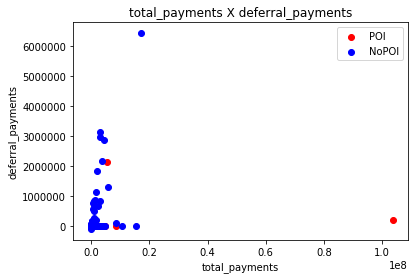

In [19]:
plt.scatter(df_copy['total_payments'][df_copy['poi'] == True], df_copy['deferral_payments'][df_copy['poi'] == True],
            color = 'r', label = 'POI')

plt.scatter(df_copy['total_payments'][df_copy['poi'] == False], df_copy['deferral_payments'][df_copy['poi'] == False],
            color = 'b', label = 'NoPOI')

    
plt.xlabel('total_payments')
plt.ylabel('deferral_payments')
plt.title('total_payments X deferral_payments')
plt.legend(loc='best')
plt.show()

Pelo gráfico notamos que há dois outliers. Como o foco do estudo são os pessoas de interesse (POI), eliminaremos apenas o outlier NoPOI.

In [20]:
df_copy['deferral_payments'].idxmax()

'FREVERT MARK A'

In [21]:
# Removendo o terceiro outlier: 'FREVERT MARK A'
df_copy = df_copy.drop('FREVERT MARK A', axis = 0)

O próximo atributo a ser verificado será o 'long_term_incentive'.

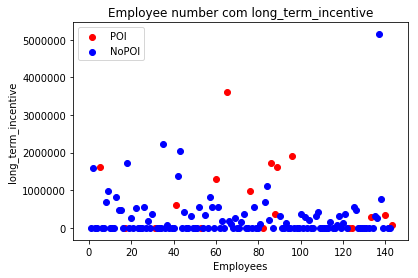

In [22]:
# Encontrando os index numéricos de POIs e NoPOIs
poi_index = []
non_poi_index = []

for i in range(len(df_copy['poi'])):
    if(df_copy['poi'][i] == True):
        poi_index.append(i+1)
    else:
        non_poi_index.append(i+1)
        
# Scatterplot
plt.scatter(poi_index, df_copy['long_term_incentive'][df_copy['poi'] == True],
            color = 'r', label = 'POI')
plt.scatter(non_poi_index, df_copy['long_term_incentive'][df_copy['poi'] == False],
            color = 'b', label = 'NoPOI')

    
plt.xlabel('Employees')
plt.ylabel('long_term_incentive')
plt.title("Employee number com long_term_incentive")
plt.legend(loc='best')
plt.show()

Notamos que há um ponto bem acima dos demais. Portanto, iremos removê-lo.

In [23]:
df_copy['long_term_incentive'].idxmax()

'MARTIN AMANDA K'

In [24]:
#Removendo o quarto outlier: 'MARTIN AMANDA K'
df_copy = df_copy.drop('MARTIN AMANDA K', axis = 0)

Os próximos atributos a serem verificados serão 'restricted_stock' e 'restricted_stock_deferred'.

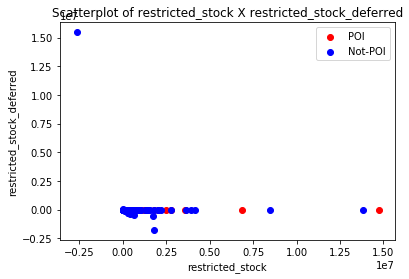

In [25]:
plt.scatter(df_copy['restricted_stock'][df_copy['poi'] == True],df_copy['restricted_stock_deferred'][df_copy['poi'] == True],
            color = 'r', label = 'POI')

plt.scatter(df_copy['restricted_stock'][df_copy['poi'] == False], df_copy['restricted_stock_deferred'][df_copy['poi'] == False],
            color = 'b', label = 'Not-POI')

    
plt.xlabel('restricted_stock')
plt.ylabel('restricted_stock_deferred')
plt.title("Scatterplot of restricted_stock X restricted_stock_deferred")
plt.legend(loc='best')
plt.show()

Podemos ver que há um outlier que temos que remover.

In [26]:
df_copy['restricted_stock_deferred'].idxmax()

'BHATNAGAR SANJAY'

In [27]:
# Removendo o quinto outlier: 'BHATNAGAR SANJAY'
df_copy = df_copy.drop('BHATNAGAR SANJAY', axis = 0)

Verificaremos agora os atributos 'from_poi_to_this_person' e 'from_this_person_to_poi'.

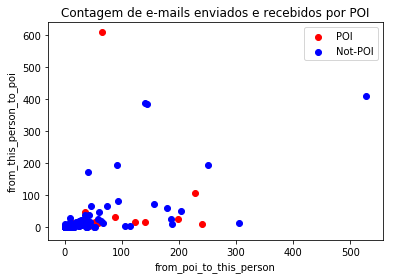

In [28]:
plt.scatter(df_copy['from_poi_to_this_person'][df_copy['poi'] == True], df_copy['from_this_person_to_poi'][df_copy['poi'] == True],
            color = 'r', label = 'POI')
plt.scatter(df_copy['from_poi_to_this_person'][df_copy['poi'] == False], df_copy['from_this_person_to_poi'][df_copy['poi'] == False],
            color = 'b', label = 'Not-POI')
    
plt.xlabel('from_poi_to_this_person')
plt.ylabel('from_this_person_to_poi')
plt.title("Contagem de e-mails enviados e recebidos por POI")
plt.legend(loc='best')
plt.show()

Notamos que o gráfico não contém pontos muito fora da realidade.<br>Porém, a proporção de e-mails enviados e recebidos seria uma medida mais correta para encontrarmos POI's do que a contagem representada acima.<br>A criação desse atributo, assim como outros que serão necessários, será feita no próximo tópico.

A célula abaixo é necessária para realizar a comparação entre o conjunto de dados com e sem os atributos criados.<br>
Para verificar o comportamento sem os dados criados, descomente a célula abaixo e não execute as células do tópico "Task 3: Create new features"

In [29]:
## Converting the modified dataframe in a dictionary

# data_dict = df_copy.to_dict('index')
# print("Total number of datapoints:",len(data_dict))
# print("Total number of features:",len(data_dict['ELLIOTT STEVEN']))

## Store to my_dataset_first for easy export below.

# my_dataset = data_dict

## Extract features and labels from dataset for local testing
# data = featureFormat(my_dataset, features_list, sort_keys = True)
# labels, features = targetFeatureSplit(data)

### Task 3: Create new feature(s) ###

- bonus_salary_ratio: Relação entre bonus e salário
- proportion_mail_from_poi: Proporção entre e-mails enviados por poi para determinada pessoa
- proportion_mail_to_poi: Proporção entre e-mails recebidos de poi de determinada pessoa

In [30]:
df_copy['bonus_salary_ratio'] = df_copy['bonus']/df_copy['salary']

In [31]:
df_copy.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,bonus_salary_ratio
METTS MARK,600000.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,...,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0,1.640294
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,...,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0,4.492666
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,...,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0,2.047490
CORDES WILLIAM R,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,...,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0,NaN
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,0.0,...,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0,6.165405


In [32]:
df_copy['proportion_mail_from_poi'] = df_copy['from_poi_to_this_person']/df_copy['from_messages'] 
df_copy['proportion_mail_to_poi'] = df_copy['from_this_person_to_poi']/df_copy['to_messages']

In [33]:
#Caso tenha ocorrido alguma divisão por zero
df_copy = df_copy.replace('inf', 0)
df_copy = df_copy.fillna(0)

In [34]:
df_copy.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,bonus_salary_ratio,proportion_mail_from_poi,proportion_mail_to_poi
METTS MARK,600000.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,...,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0,1.640294,1.310345,0.001239
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,...,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0,4.492666,0.000000,0.000000
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,...,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0,2.047490,0.000000,0.000000
CORDES WILLIAM R,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,...,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0,0.000000,0.833333,0.000000
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,0.0,...,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0,6.165405,1.000000,0.020096


In [35]:
# Convertendo o dataframe modificado para um dicionário
data_dict = df_copy.to_dict('index')
print("Total number of datapoints:",len(data_dict))
print("Total number of features:",len(data_dict['ELLIOTT STEVEN']))

Total number of datapoints: 141
Total number of features: 23


In [36]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

In [37]:
# features_list atualizado
features_list = ['poi','salary', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees',
                 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person',
				 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other',
				 'restricted_stock', 'restricted_stock_deferred','shared_receipt_with_poi',
                 'to_messages', 'total_payments', 'total_stock_value', 'bonus_salary_ratio',
                 'proportion_mail_from_poi', 'proportion_mail_to_poi']

In [38]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers ###

Os algoritmos escolhidos são:
- Decision Tree
- SVM
- GaussianNB
- Random Forest
- AdaBoost

In [39]:
### Split data into training and testing datasets
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [40]:
# Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
start = time()
tree_clf.fit(features_train, labels_train)
end = time()
tree_fit_time = end - start
print("Tempo de treinamento:", tree_fit_time, "segundos")
start = time()
pred = tree_clf.predict(features_test)
end = time()
tree_pred_time = end - start
print("Tempo de previsão:", tree_pred_time, "segundos")
print()
report = classification_report(labels_test, pred)
print(report)

Tempo de treinamento: 0.003002166748046875 segundos
Tempo de previsão: 0.0009996891021728516 segundos

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91        36
         1.0       0.33      0.17      0.22         6

   micro avg       0.83      0.83      0.83        42
   macro avg       0.60      0.56      0.56        42
weighted avg       0.79      0.83      0.81        42



In [41]:
#SVM
svm_clf = SVC(gamma='auto', random_state=42)
start = time()
svm_clf.fit(features_train, labels_train)
end = time()
svm_fit_time = end - start
print("Tempo de treinamento:", svm_fit_time, "segundos")
start = time()
pred = svm_clf.predict(features_test)
end = time()
svm_pred_time = end - start
print("Tempo de previsão:", svm_pred_time, "segundos")
print()
report = classification_report(labels_test, pred)
print(report)

Tempo de treinamento: 0.005007505416870117 segundos
Tempo de previsão: 0.001998424530029297 segundos

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        36
         1.0       0.00      0.00      0.00         6

   micro avg       0.86      0.86      0.86        42
   macro avg       0.43      0.50      0.46        42
weighted avg       0.73      0.86      0.79        42



c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
#GaussianNB
gaussian_clf = GaussianNB()
start = time()
gaussian_clf.fit(features_train, labels_train)
end = time()
gaussian_fit_time = end - start
print("Tempo de treinamento:", gaussian_fit_time, "segundos")
start = time()
pred = gaussian_clf.predict(features_test)
end = time()
gaussian_pred_time = end - start
print("Tempo de previsão:", gaussian_pred_time, "segundos")
print()
report = classification_report(labels_test, pred)
print(report)

Tempo de treinamento: 0.0030035972595214844 segundos
Tempo de previsão: 0.0010008811950683594 segundos

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95        36
         1.0       0.75      0.50      0.60         6

   micro avg       0.90      0.90      0.90        42
   macro avg       0.84      0.74      0.77        42
weighted avg       0.90      0.90      0.90        42



In [43]:
#Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
start = time()
rf_clf.fit(features_train, labels_train)
end = time()
rf_fit_time = end - start
print("Tempo de treinamento:", rf_fit_time, "segundos")
start = time()
pred = rf_clf.predict(features_test)
end = time()
rf_pred_time = end - start
print("Tempo de previsão:", rf_pred_time, "segundos")
print()
report = classification_report(labels_test, pred)
print(report)

Tempo de treinamento: 0.13008689880371094 segundos
Tempo de previsão: 0.0120086669921875 segundos

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        36
         1.0       0.00      0.00      0.00         6

   micro avg       0.86      0.86      0.86        42
   macro avg       0.43      0.50      0.46        42
weighted avg       0.73      0.86      0.79        42



c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
#AdaBoost
ada_clf = AdaBoostClassifier(random_state=42)
start = time()
ada_clf.fit(features_train, labels_train)
end = time()
ada_fit_time = end - start
print("Tempo de treinamento:", ada_fit_time, "segundos")
start = time()
pred = ada_clf.predict(features_test)
end = time()
ada_pred_time = end - start
print("Tempo de previsão:", ada_pred_time, "segundos")
print()
report = classification_report(labels_test, pred)
print(report)

Tempo de treinamento: 0.09606647491455078 segundos
Tempo de previsão: 0.010005474090576172 segundos

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92        36
         1.0       0.50      0.17      0.25         6

   micro avg       0.86      0.86      0.86        42
   macro avg       0.69      0.57      0.59        42
weighted avg       0.82      0.86      0.83        42



O algoritmo GaussianNB, dentre os algoritmos testados, obteve o melhor desempenho (maior f1-score).

### Task 5: Tune your classifier ###

Ajustar o algoritmo para aprendizado de máquina significa escolher os melhores valores de parâmetro para o algoritmo que fornece um desempenho otimizado.<br>
Se não for ajustado corretamente, o limite de decisão feito usando o algoritmo e os dados do conjunto de treinamento não será capaz de fornecer corretamente a melhor previsão para os dados do conjunto de testes, uma vez que as chances de ter alta polarização e alta variância ocorrem.<br>
<br>
GridSearch é uma abordagem para o ajuste de parâmetros que irá construir e avaliar metodicamente um modelo para cada combinação de parâmetros de algoritmo especificados em uma grade.

In [45]:
#Decision Tree
parameters = dict(min_samples_split = range(2,50), max_depth = range(2,20))
tree_gs = GridSearchCV(tree_clf, parameters, cv=5)
start = time()
tree_gs.fit(features_train, labels_train)
end = time()
tree_gs_fit_time = end - start
print("Tempo de treinamento: ", tree_gs_fit_time, "segundos")
start = time()
pred = tree_gs.predict(features_test)
end = time()
tree_gs_pred_time = end - start
print("Tempo de previsão: ", tree_gs_pred_time, "segundos")
print()
tree_gs_clf = tree_gs.best_estimator_
report = classification_report(labels_test, pred)
print(report)
print()
print("Descrição da melhor Árvore de Decisão:")
print()
print(tree_gs_clf)

Tempo de treinamento:  8.92600393295288 segundos
Tempo de previsão:  0.0 segundos

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        36
         1.0       1.00      0.17      0.29         6

   micro avg       0.88      0.88      0.88        42
   macro avg       0.94      0.58      0.61        42
weighted avg       0.90      0.88      0.84        42


Descrição da melhor Árvore de Decisão:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


c:\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [46]:
#SVM
estimators = [('reduce_dim', PCA()), ('clf', svm_clf)]
pipe = Pipeline(estimators)
parameters = {'clf__C':[0.001,0.1,10,100,1000], 'clf__gamma':[1.0,0.1,0.01]}
svm_gs = GridSearchCV(pipe, parameters, cv=5)
start = time()
svm_gs.fit(features_train, labels_train)
end = time()
svm_gs_fit_time = end - start
print("Tempo de treinamento: ", svm_gs_fit_time, "segundos")
start = time()
pred = svm_gs.predict(features_test)
end = time()
svm_gs_pred_time = end - start
print("Tempo de previsão: ", svm_gs_pred_time, "segundos")
print()
svm_gs_clf = svm_gs.best_estimator_
report = classification_report(labels_test, pred)
print(report)
print()
print("Descrição da melhor Máquina de Vetores de Suporte:")
print()
print(svm_gs_clf)

Tempo de treinamento:  0.39426660537719727 segundos
Tempo de previsão:  0.0 segundos

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        36
         1.0       0.00      0.00      0.00         6

   micro avg       0.86      0.86      0.86        42
   macro avg       0.43      0.50      0.46        42
weighted avg       0.73      0.86      0.79        42


Descrição da melhor Máquina de Vetores de Suporte:

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


c:\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
# GaussianNB
pipeline = Pipeline(steps = [("SKB", SelectKBest()), ("clf",gaussian_clf)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 5, scoring = 'f1')

start = time()
grid.fit(features, labels)
end = time()
grid_fit_time = end - start
print("Tempo de Treinamento Grid:", grid_fit_time, "segundos")

# best algorithm
gaussian_gs_clf = grid.best_estimator_

# refit the best algorithm:
gaussian_gs_clf.fit(features_train, labels_train)

start = time()
pred = gaussian_gs_clf.predict(features_test)
end = time()
gaussian_gs_pred_time = end - start
print("Tempo de previsão do Melhor GaussianNB:", gaussian_gs_pred_time, "segundos")

report = classification_report(labels_test, pred)
print(report)

c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [10] are constant.
  UserWarning)
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [10] are constant.
  UserWarning)
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [10] are constant.
  UserWarning)
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Featu

Tempo de Treinamento Grid: 0.5063381195068359 segundos
Tempo de previsão do Melhor GaussianNB: 0.0 segundos
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        36
         1.0       0.50      0.50      0.50         6

   micro avg       0.86      0.86      0.86        42
   macro avg       0.71      0.71      0.71        42
weighted avg       0.86      0.86      0.86        42



c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [10] are constant.
  UserWarning)
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [10] are constant.
  UserWarning)
c:\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be remo

In [48]:
#Random Forest
parameters = dict(n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200])
rf_gs = GridSearchCV(rf_clf, parameters, cv=5)
start = time()
rf_gs.fit(features_train, labels_train)
end = time()
rf_gs_fit_time = end - start
print("Tempo de treinamento: ", rf_gs_fit_time, "segundos")
start = time()
pred = rf_gs.predict(features_test)
end = time()
rf_gs_pred_time = end - start
print("Tempo de previsão: ", rf_gs_pred_time, "segundos")
print()
rf_gs_clf = rf_gs.best_estimator_
report = classification_report(labels_test, pred)
print(report)
print()
print("Descrição da melhor Floresta Aleatória:")
print()
print(rf_gs_clf)

Tempo de treinamento:  2.7208309173583984 segundos
Tempo de previsão:  0.004001617431640625 segundos

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        36
         1.0       1.00      0.17      0.29         6

   micro avg       0.88      0.88      0.88        42
   macro avg       0.94      0.58      0.61        42
weighted avg       0.90      0.88      0.84        42


Descrição da melhor Floresta Aleatória:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


c:\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
# AdaBoost

parameters = dict(n_estimators = [50, 100, 200, 400],
                  learning_rate = [0.01, 0.1, 1])
ada_gs = GridSearchCV(ada_clf, parameters, cv=5)
start = time()
ada_gs.fit(features_train, labels_train)
end = time()
ada_gs_fit_time = end - start
print("Tempo de treinamento: ", ada_gs_fit_time, "segundos")
start = time()
pred = ada_gs.predict(features_test)
end = time()
ada_gs_pred_time = end - start
print("Tempo de previsão: ", ada_gs_pred_time, "segundos")
print()
ada_gs_clf = ada_gs.best_estimator_
report = classification_report(labels_test, pred)
print(report)
print()
print("Descrição da melhor Floresta Aleatória:")
print()
print(ada_gs_clf)

c:\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tempo de treinamento:  17.49677085876465 segundos
Tempo de previsão:  0.06604385375976562 segundos

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91        36
         1.0       0.00      0.00      0.00         6

   micro avg       0.83      0.83      0.83        42
   macro avg       0.43      0.49      0.45        42
weighted avg       0.73      0.83      0.78        42


Descrição da melhor Floresta Aleatória:

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=400, random_state=42)


Dentre todos os algoritmos, GaussianNB se mostrou o mais eficiente para usarmos.<br>
Os valores da precisão (precision), recall e f1-score - além do tempo de treinamento e previsão - se mostraram mais eficientes em comparação aos outros algoritmos usados.

### Task 6: Dump your classifier, dataset, and features_list ###

In [50]:
clf = gaussian_gs_clf
dump_classifier_and_data(clf, my_dataset, features_list)

### Validação ###

Validação de modelo é definida como o processo em que um modelo treinado é avaliado com um conjunto de dados de teste.<br>
O conjunto de dados de teste é uma parte separada do mesmo conjunto de dados do qual o conjunto de treinamento é derivado.<br>
O principal objetivo do uso do conjunto de dados de teste é testar a capacidade de generalização de um modelo treinado.<br>
A validação do modelo é realizada após o treinamento do modelo.<br>
<br>
Treinar o modelo de previsão e testá-lo no mesmo conjunto de dados usado para teste é um erro clássico.<br>
Um modelo que apenas repetiria os rótulos das amostras que acabou de ver teria uma pontuação perfeita, mas não poderia prever nada de útil em dados ainda não vistos. Isso é chamado 'overfitting'.<br>
Para evitá-lo é comum ao realizar um experimento de aprendizado de máquina (supervisionado), reter parte dos dados disponíveis como um conjunto de testes.<br>
<br>
Neste projeto para validação, o StratifiedShuffleSplit é usado porque o conjunto de dados usado é muito pequeno.<br>
Este método faz uma "Validação cruzada de permutação aleatória".<br>

'StratifiedShuffleSplit' é usado quando há poucas observações em nossos dados que estamos tentando prever (como é o nosso caso).<br>
Em vez de especificar um teste explícito e a divisão de dados de treinamento (que é fixa), aleatoriamente "misturamos" nossos dados, criando dados de teste e treinamento. A divisão aleatória estratificada também é usada para lidar com desequilíbrios de classe nos dados. Isso é muito importante, especialmente porque há pouquíssimos POIs nos dados.<br>
<br>
'StratifiedShuffleSplit' irá criar subconjuntos de trem / validação (conforme o código acima, ele irá criar 100 deles). Internamente, 'GridSearchCV' estimará os modelos usando os 100 subconjuntos de trem e validará o modelo no subconjunto 100 de validação. Assim, o uso do conjunto de dados completo permitirá que os subconjuntos de treinamento e validação incluam o maior número de POIs possível.

### Evaluation Metrics ###

O foco é otimizar a precisão (precision) e o recall, por isso usamos f1-score como a medida-chave para o desempenho dos algoritmos.<br>
O f1-score considera tanto a precisão quanto o recall para calcular a pontuação.<br>
Além disso, para 'StratifiedShuffleSplit', o parâmetro n_splits = 1000 é usado.

- <b>Accuracy:</b> é uma relação entre a observação corretamente prevista e o total de observações.
- <b>Precision:</b> é a razão de observações positivas previstas corretamente para o total de observações positivas previstas.
- <b>Recall:</b> é a razão de observações positivas preditas corretamente para todas as observações na classe real.
- <b>F1-Score:</b> é a média ponderada de Precision e Recall. Portanto, essa pontuação leva em conta tanto os falsos positivos quanto os falsos negativos.

Valores obtidos depois de rodar o arquivo 'tester.py' com os dados criados:

- <b>Algoritmo:</b>GaussianNB
- <b>Accuracy:</b> 0.85271
- <b>Precision:</b> 0.48128
- <b>Recall:</b> 0.0.39850
- <b>F1-Score:</b> 0.43600

Valores obtidos depois rodar o arquivo 'tester.py' sem os dados criados:

- <b>Algoritmo:</b>GaussianNB
- <b>Accuracy:</b> 0.85343
- <b>Precision:</b> 0.48415
- <b>Recall:</b> 0.0.39700
- <b>F1-Score:</b> 0.43626

Notamos que os dados criados não fizeram muita diferença na qualidade do algoritmo.